## 通过神经网络预测房价
在这个项目中，我们希望能够构建神经网络来预测房屋的价格

首先，我们导入一些必要的库

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn

%matplotlib inline
%load_ext autoreload
%autoreload 2

读取训练集和测试集的数据

In [2]:
train = pd.read_csv('./all/train.csv')
test = pd.read_csv('./all/test.csv')
#train = pd.read_csv('./all/train.csv')
#test = pd.read_csv('./all/test.csv')

可以具体看看前面 5 个训练集长什么样子，可以看到，前面都是这个房屋的属性，最后是房屋的价格

In [3]:
train.head()
#train.head()
#test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


接着我们可以看看训练集和测试集分别有多少个样本

In [4]:
print('一共有 {} 个训练集样本'.format(train.shape[0]))
print('一共有 {} 个测试集样本'.format(test.shape[0]))
#print('一共有 {} 个训练集样本'.format(train.shape[0]))
#print('一共有 {} 个测试集样本'.format(test.shape[0]))

一共有 1460 个训练集样本
一共有 1459 个测试集样本


接着我们开始对数据进行处理，首先我们取出**第二个特征**到**倒数第二个特征**，这些特征作为我们神经网络的输入特征

In [5]:
all_features = pd.concat((train.loc[:, 'MSSubClass':'SaleCondition'],
                          test.loc[:, 'MSSubClass':'SaleCondition']))

#all_features = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
#                         train.loc[:,'MSSubClass':'SaleCondition']))
#all_features.dtypes

接着我们需要进行数据标准化，对于所有的数值特征，我们都会减去均值，除以方差

In [6]:
numeric_feats = all_features.dtypes[all_features.dtypes != "object"].index # 取出所有的数值特征
#numeric_feats = all_features.dtypes[all_features.dtypes != 'object'].index
#DataFrame.dtypes 是返回每一列的dtypes及其dtype属性作为一个dataframe
#这里的!= 则会返回一个true/falsedataframe
#[]里传入的是与all_features.dtypes同型的true/false矩阵
#.index取DataFrame里的index
# 减去均值，除以方差

all_features[numeric_feats] = all_features[numeric_feats].apply(lambda x: (x - x.mean()) 
                                                                / (x.std()))
#all_features[numeric_feats] = all_features[numeric_feats].apply(lambda x:(x-x.mean()/x.std()))
all_features.head()
#df[]支持直接按列索引
#.apply()默认对每列操作

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,0.067320,RL,-0.184443,-0.217841,Pave,NaN,Reg,Lvl,AllPub,Inside,...,-0.285886,-0.063139,NaN,NaN,NaN,-0.089577,-1.551918,0.157619,WD,Normal
1,-0.873466,RL,0.458096,-0.072032,Pave,NaN,Reg,Lvl,AllPub,FR2,...,-0.285886,-0.063139,NaN,NaN,NaN,-0.089577,-0.446848,-0.602858,WD,Normal
2,0.067320,RL,-0.055935,0.137173,Pave,NaN,IR1,Lvl,AllPub,Inside,...,-0.285886,-0.063139,NaN,NaN,NaN,-0.089577,1.026577,0.157619,WD,Normal
3,0.302516,RL,-0.398622,-0.078371,Pave,NaN,IR1,Lvl,AllPub,Corner,...,-0.285886,-0.063139,NaN,NaN,NaN,-0.089577,-1.551918,-1.363335,WD,Abnorml
4,0.067320,RL,0.629439,0.518814,Pave,NaN,IR1,Lvl,AllPub,FR2,...,-0.285886,-0.063139,NaN,NaN,NaN,-0.089577,2.131647,0.157619,WD,Normal


In [7]:
# 对预测的价格取 log
train['SalePrice'] = np.log(train['SalePrice'])
#train['SalePrice'] = np.log(train['SalePrice'])
train['SalePrice'].head()

0    12.247694
1    12.109011
2    12.317167
3    11.849398
4    12.429216
Name: SalePrice, dtype: float64

如果你仔细看看上面的特征，你会发现，除了数值特征之外，还有很多非数值特征，这些特征我们没有办法将其转换成数值表示，所以我们通过 pandas 的内置函数将其转换成种类表示

比如 **MSZoning** 有两种可能，一种是 RL，一种是 RM，那么我们就将这个特征变成两个新的特征，RL 和 RM，如果这个数据在 **MSZoning** 上是 RL，那么 RL 取 1，RM 取 0；反之如果这个特征是 RM，那么 RL 取 0，RM 取 1.

| RL | RM |
|-|-|
| 0 | 1 |
| 1 | 0 |

In [8]:
all_features = pd.get_dummies(all_features, dummy_na=True)
#all_features = pd.get_dummies(all_features,dummy_na = True)
#all_features.head()

除此之外，我们会发现整个数据中有一些丢失数据，这些丢失数据都是 'NA'，我们没有办法将这些数据输入到网络中，所以需要对这些丢失数据进行赋值，这里我们将数据的均值填入到丢失数据中

In [9]:
all_features.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_Oth,SaleType_WD,SaleType_nan,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleCondition_nan
0,0.067320,-0.184443,-0.217841,0.646073,-0.507197,1.046078,0.896679,0.523038,0.580708,-0.29303,...,0,1,0,0,0,0,0,1,0,0
1,-0.873466,0.458096,-0.072032,-0.063174,2.187904,0.154737,-0.395536,-0.569893,1.177709,-0.29303,...,0,1,0,0,0,0,0,1,0,0
2,0.067320,-0.055935,0.137173,0.646073,-0.507197,0.980053,0.848819,0.333448,0.097840,-0.29303,...,0,1,0,0,0,0,0,1,0,0
3,0.302516,-0.398622,-0.078371,0.646073,-0.507197,-1.859033,-0.682695,-0.569893,-0.494771,-0.29303,...,0,1,0,1,0,0,0,0,0,0
4,0.067320,0.629439,0.518814,1.355319,-0.507197,0.947040,0.753100,1.381770,0.468770,-0.29303,...,0,1,0,0,0,0,0,1,0,0


In [10]:
all_features = all_features.fillna(all_features.mean())
#这里必须赋值，因为是浅拷贝
#这里已经没意义了吧，因为nan也被转换为变量了
feat_dim = all_features.shape[1]

#all_features = all_features.fillna(all_features.mean())
#feat_dim = all_features.shape[1]
#all_features.head()

前面我们已经做好了数据的预处理，下面我们将所有的训练集和验证集都取出成为一个 numpy 的数组

In [11]:
num_train = int(0.9 * train.shape[0]) # 划分训练样本和验证集样本
indices = np.arange(train.shape[0])
np.random.shuffle(indices)  # shuffle 顺序
#原地算法
train_indices = indices[:num_train]
valid_indices = indices[num_train:]

#num_train = int(0.9*train.shape[0])
#indices = np.random.shuffle(np.arange(train.shape[0]))
#train_indices = indices[:num_train]
#train_indices = indices[num_train:]

# 提取训练集和验证集的特征
train_features = all_features.iloc[train_indices].values.astype(np.float32)
#.values返回的是np.array,astype是为了把object变成np.float32
train_features = torch.from_numpy(train_features)
valid_features = all_features.iloc[valid_indices].values.astype(np.float32)
valid_features = torch.from_numpy(valid_features)
train_valid_features = all_features[:train.shape[0]].values.astype(np.float32)
train_valid_features = torch.from_numpy(train_valid_features)

#train_features = all_features.iloc[train_indices].values.astype(np.float32)
#train_features = torch.from_numpy(train_features)

# 提取训练集和验证集的label
train_labels = train['SalePrice'].values[train_indices, None].astype(np.float32)
#None会在返回值里再加入一个[],使得维度增加，如果是一个1维array则会变成列向量
train_labels = torch.from_numpy(train_labels)
valid_labels = train['SalePrice'].values[valid_indices, None].astype(np.float32)
valid_labels = torch.from_numpy(valid_labels)
train_valid_labels = train['SalePrice'].values[:, None].astype(np.float32)
train_valid_labels = torch.from_numpy(train_valid_labels)
#train_labels = train['SalePrice'].values[train_indices, None].astype(np.float32)
#train_labels = torch.from_numpy(train_labels)

In [12]:
test_features = all_features[train.shape[0]:].values.astype(np.float32)
test_features = torch.from_numpy(test_features)

In [13]:
all_features.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_Oth,SaleType_WD,SaleType_nan,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleCondition_nan
0,0.067320,-0.184443,-0.217841,0.646073,-0.507197,1.046078,0.896679,0.523038,0.580708,-0.29303,...,0,1,0,0,0,0,0,1,0,0
1,-0.873466,0.458096,-0.072032,-0.063174,2.187904,0.154737,-0.395536,-0.569893,1.177709,-0.29303,...,0,1,0,0,0,0,0,1,0,0
2,0.067320,-0.055935,0.137173,0.646073,-0.507197,0.980053,0.848819,0.333448,0.097840,-0.29303,...,0,1,0,0,0,0,0,1,0,0
3,0.302516,-0.398622,-0.078371,0.646073,-0.507197,-1.859033,-0.682695,-0.569893,-0.494771,-0.29303,...,0,1,0,1,0,0,0,0,0,0
4,0.067320,0.629439,0.518814,1.355319,-0.507197,0.947040,0.753100,1.381770,0.468770,-0.29303,...,0,1,0,0,0,0,0,1,0,0


下面是构建神经网络的地方，可以构建任意想要的神经网络

In [100]:
hidden_layer = 128
def get_model():
    net = nn.Sequential(
        nn.Linear(feat_dim, hidden_layer),
        nn.ReLU(),
        nn.Linear(hidden_layer,hidden_layer),
        nn.ReLU(),
        #nn.functional.conv1d(),
        #nn.Conv1d(1,1),
        #卷积池化
        #softmax，tanh都可以加进来
        #能否借箭resnet的思路？
        #tanh似乎不好使
        #resnet怎么样？
        nn.Linear(hidden_layer,hidden_layer),
        nn.ReLU(),
        nn.Linear(hidden_layer,hidden_layer),
        nn.ReLU(),
        nn.Linear(hidden_layer,hidden_layer),
        nn.ReLU(),
        nn.Linear(hidden_layer,hidden_layer),
        nn.ReLU(),
        nn.Linear(hidden_layer,hidden_layer),
        nn.ReLU(),
        nn.Linear(hidden_layer,hidden_layer),
        nn.ReLU(),
        nn.Linear(hidden_layer,hidden_layer),
        nn.ReLU(),
        nn.Linear(hidden_layer,hidden_layer),
        nn.ReLU(),
        nn.Linear(hidden_layer,hidden_layer),
        nn.ReLU(),
        nn.Linear(hidden_layer,hidden_layer),
        nn.ReLU(),
        nn.Linear(hidden_layer,hidden_layer),
        nn.ReLU(),
        nn.Linear(hidden_layer,hidden_layer),
        nn.ReLU(),
        nn.Linear(hidden_layer,hidden_layer),
        nn.ReLU(),
        nn.Linear(hidden_layer,hidden_layer),
        nn.ReLU(),
        nn.Linear(hidden_layer,hidden_layer),
        nn.ReLU(),
        nn.Linear(hidden_layer,hidden_layer),
        nn.ReLU(),
        nn.Linear(hidden_layer,hidden_layer),
        nn.ReLU(),
        nn.Linear(hidden_layer,hidden_layer),
        nn.ReLU(),
        nn.Linear(hidden_layer,hidden_layer),
        nn.ReLU(),
        #想着有负数能增加模型表达能力，所以最后一层没加
        #不知道加不加好了
        nn.Linear(hidden_layer,1)
    )
    return net
#维度随机似乎有利于结果更优
net = get_model()
print(net)

Sequential(
  (0): Linear(in_features=331, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=128, bias=True)
  (3): ReLU()
  (4): Linear(in_features=128, out_features=128, bias=True)
  (5): ReLU()
  (6): Linear(in_features=128, out_features=128, bias=True)
  (7): ReLU()
  (8): Linear(in_features=128, out_features=128, bias=True)
  (9): ReLU()
  (10): Linear(in_features=128, out_features=128, bias=True)
  (11): ReLU()
  (12): Linear(in_features=128, out_features=128, bias=True)
  (13): ReLU()
  (14): Linear(in_features=128, out_features=128, bias=True)
  (15): ReLU()
  (16): Linear(in_features=128, out_features=128, bias=True)
  (17): ReLU()
  (18): Linear(in_features=128, out_features=128, bias=True)
  (19): ReLU()
  (20): Linear(in_features=128, out_features=128, bias=True)
  (21): ReLU()
  (22): Linear(in_features=128, out_features=128, bias=True)
  (23): ReLU()
  (24): Linear(in_features=128, out_features=128, bias=True)
  (25): ReLU()
  (26): Li

在评估模型的时候，为了保证大的价格和小的价格对模型都有着近似相同的影响，我们不会直接使用前面定义的均方误差作为最后的评价函数，我们会对预测的价格和真实的价格取 log，然后计算他们之间均方误差的平方根来作为评价指标，这里的指标我们已经在 `utils.py` 中实现了，感兴趣的同学可以去看看。

In [84]:
from utils import train_model, pred

epoch: 10, train rmse: 0.04921, valid rmse: 0.11646

epoch: 20, train rmse: 0.04415, valid rmse: 0.11437

epoch: 30, train rmse: 0.04335, valid rmse: 0.11406

epoch: 40, train rmse: 0.04305, valid rmse: 0.11435

epoch: 50, train rmse: 0.04332, valid rmse: 0.11513



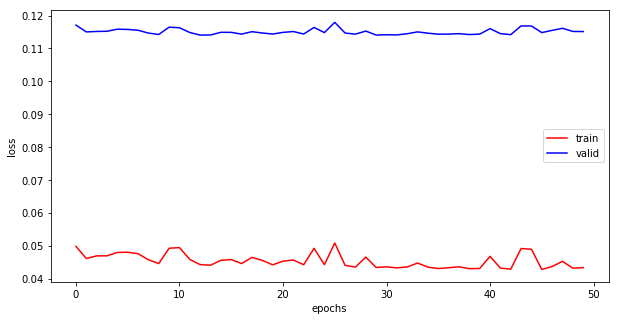

In [112]:
# 可以调整的超参
batch_size = 256
#调batch_size居然也管用
epochs = 50
lr = 2e-5
#我觉得lr与wd应该有一种对应关系
#输出尽可能多位的loss来判断是否震荡
#人为减小学习率...
#可以在训练循环中，加一句衰减率
#疯狂训练...
#约到低谷处，越要减小学习率，否则会振荡！
#如果有人能把神经网络的结果化为表达式，那一定是个大成就
#多维函数近似表达式
#train loss降，valid loss生，明显的过拟合
#这时是否应该稍微调高一点lr时期脱离过拟合区域？
#训练时间也太长了
#至少训了3000轮
wd = 2e-4
#过拟合时可调节wd,惩罚项
use_gpu = False

#net = get_model()
train_model(net, train_features, train_labels, valid_features, valid_labels, epochs, 
            batch_size, lr, wd, use_gpu)

当我们构建好了训练的过程，下面就开始了不断地调参尝试，最后得到一个效果最好的模型

epoch: 10, train rmse: 12.06109

epoch: 20, train rmse: 12.05147

epoch: 30, train rmse: 12.04180

epoch: 40, train rmse: 12.03266

epoch: 50, train rmse: 12.02347

epoch: 60, train rmse: 12.01380

epoch: 70, train rmse: 12.00286

epoch: 80, train rmse: 11.99098

epoch: 90, train rmse: 11.97410

epoch: 100, train rmse: 11.95660



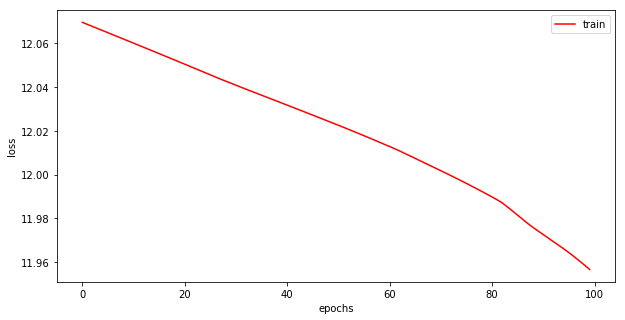

In [71]:
net = get_model()
train_model(net, train_valid_features, train_valid_labels, None, None, epochs, 
            batch_size, lr, wd, use_gpu)
#拟合最好结果0.098
#当然有可能过拟合

运行下面的代码，可以通过训练好的模型预测 testset 的结果，会在当前目录生成 `submission.csv` 用于提交

In [104]:
pred(net, test, test_features)
torch.save(net,'net.pkl')